# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [45]:
import torch
import torch.nn as nn

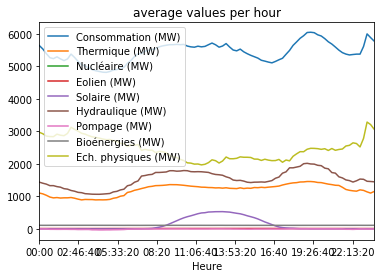

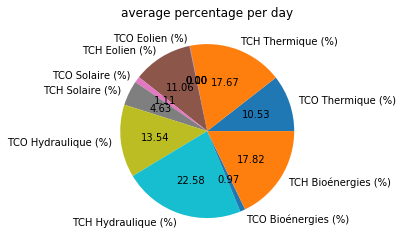

(115233, 81)
(29003, 18)


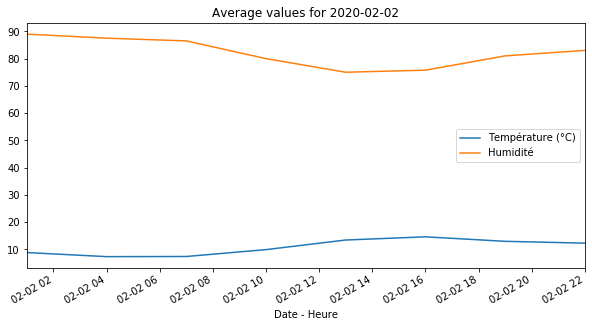

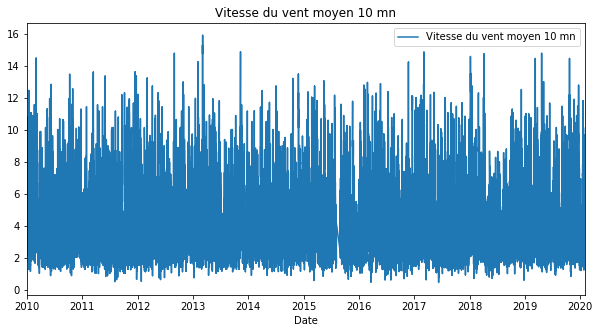

In [46]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

In [47]:
def extractDate(data):
    data['Minute'] = data["Heure"].apply(lambda x : x.minute)
    data["Heure"] = data["Heure"].apply(lambda x : x.hour)
    data["Heure"] = data["Heure"].values.astype(np.float64)
    data["Minute"] = data["Minute"].values.astype(np.float64)
    return data

In [48]:
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
# converting data_meteo['Date']'s' type to match data['Date']'s type
data_meteo['Date'] = pd.to_datetime(data_meteo['Date'])
print(data['Date'].dtypes == data_meteo['Date'].dtypes)

False
True


In [49]:
data_meteo['Date - Heure'] = pd.to_datetime(data_meteo['Date - Heure'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print(data.dtypes)
data_meteo.dtypes

Code INSEE région                    int64
Région                              object
Nature                              object
Date                        datetime64[ns]
Heure                               object
Date - Heure           datetime64[ns, UTC]
Consommation (MW)                  float64
Thermique (MW)                     float64
Nucléaire (MW)                     float64
Eolien (MW)                        float64
Solaire (MW)                       float64
Hydraulique (MW)                   float64
Pompage (MW)                       float64
Bioénergies (MW)                   float64
Ech. physiques (MW)                float64
TCO Thermique (%)                  float64
TCH Thermique (%)                  float64
TCO Nucléaire (%)                  float64
TCH Nucléaire (%)                  float64
TCO Eolien (%)                     float64
TCH Eolien (%)                     float64
TCO Solaire (%)                    float64
TCH Solaire (%)                    float64
TCO Hydraul

Date                                                datetime64[ns]
Annee                                                        int64
Heure                                                       object
Date - Heure                                   datetime64[ns, UTC]
Pression au niveau mer                                     float64
Variation de pression en 3 heures                          float64
Type de tendance barométrique                              float64
Direction du vent moyen 10 mn                              float64
Vitesse du vent moyen 10 mn                                float64
Point de rosée                                             float64
Humidité                                                   float64
Temps présent                                              float64
Pression station                                           float64
Rafales sur une période                                    float64
Periode de mesure de la rafale                             flo

In [50]:
# scaling the training data
TRAIN_SPLIT = 400 # size of the training dataset
print(data.shape)
print(data_meteo.shape)
data_train = pd.concat([data, data_meteo], axis=1, join='inner')
data_train

(4512, 28)
(29003, 21)


Code INSEE région                      Région                   Nature  \
0                    93  Provence-Alpes-Côte d'Azur       Données temps réel   
1                    93  Provence-Alpes-Côte d'Azur       Données temps réel   
2                    93  Provence-Alpes-Côte d'Azur       Données temps réel   
3                    93  Provence-Alpes-Côte d'Azur       Données temps réel   
4                    93  Provence-Alpes-Côte d'Azur       Données temps réel   
...                 ...                         ...                      ...   
4507                 93  Provence-Alpes-Côte d'Azur  Données prévisionnelles   
4508                 93  Provence-Alpes-Côte d'Azur  Données prévisionnelles   
4509                 93  Provence-Alpes-Côte d'Azur  Données prévisionnelles   
4510                 93  Provence-Alpes-Côte d'Azur  Données prévisionnelles   
4511                 93  Provence-Alpes-Côte d'Azur  Données prévisionnelles   

           Date     Heure              Date - Heure  Consommation (MW)  \
0    2020-01-01  00:30:00 2019-12-31 23:30:00+00:00             5759.0   
1    2020-01-01  01:15:00 2020-01-01 00:15:00+00:00             5740.0   
2    2020-01-01  02:30:00 2020-01-01 01:30:00+00:00             5644.0   
3    2020-01-01  02:45:00 2020-01-01 01:45:00+00:00             5527.0   
4    2020-01-01  04:00:00 2020-01-01 03:00:00+00:00             5237.0   
...         ...       ...                       ...                ...   
4507 2020-02-16  14:30:00 2020-02-16 13:30:00+00:00             4699.0   
4508 2020-02-16  16:30:00 2020-02-16 15:30:00+00:00             4407.0   
4509 2020-02-16  18:45:00 2020-02-16 17:45:00+00:00             5271.0   
4510 2020-02-16  20:45:00 2020-02-16 19:45:00+00:00             5184.0   
4511 2020-02-16  21:45:00 2020-02-16 20:45:00+00:00             4956.0   

      Thermique (MW)  Nucléaire (MW)  Eolien (MW)  ...  Temps présent  \
0             1402.0             NaN          2.0  ...       6.000000   
1             1249.0             NaN          1.0  ...      31.666667   
2             1020.0             NaN          1.0  ...      21.000000   
3              711.0             NaN          1.0  ...      45.000000   
4              236.0             NaN          1.0  ...      35.250000   
...              ...             ...          ...  ...            ...   
4507             NaN             NaN          NaN  ...       1.333333   
4508             NaN             NaN          NaN  ...       1.500000   
4509             NaN             NaN          NaN  ...       1.333333   
4510             NaN             NaN          NaN  ...       1.333333   
4511             NaN             NaN          NaN  ...       1.500000   

      Pression station  Rafales sur une période  \
0              96062.5                    6.550   
1              95780.0                    8.325   
2              95772.5                   11.300   
3              96005.0                    9.900   
4              96112.5                   12.475   
...                ...                      ...   
4507           97802.5                   10.425   
4508           97715.0                   14.275   
4509           97652.5                   16.325   
4510           97602.5                   13.750   
4511           97707.5                    9.125   

      Periode de mesure de la rafale  Précipitations dans la dernière heure  \
0                              -10.0                                   0.20   
1                              -10.0                                   0.20   
2                              -10.0                                   0.00   
3                              -10.0                                   0.35   
4                              -10.0                                   0.10   
...                              ...                                    ...   
4507                           -10.0                                   0.00   
4508                           -10

In [51]:
# target definition
target_data = data[["Consommation (MW)"]][:TRAIN_SPLIT]
# data_train_mean = target_data["Consommation (MW)"].mean()
# data_train_std = target_data["Consommation (MW)"].std()
# target_data["Consommation (MW)"] = (target_data["Consommation (MW)"]-data_train_mean)/data_train_std
# target_data[["Date", "Heure"]] = target_data[["Date", "Heure"]].values.astype(np.float64)
# target_data = extractDate(target_data)
target_data

Consommation (MW)
0               5759.0
1               5740.0
2               5644.0
3               5527.0
4               5237.0
..                 ...
395             5992.0
396             6134.0
397             6160.0
398             6183.0
399             5746.0

[400 rows x 1 columns]

In [52]:
# number of criterias : Date - Time
nbIn = data_train.shape[1]
# neural network statistics
nbOut = 1
nbHidden = 100
# définition of the neural network
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork

Sequential(
  (0): Linear(in_features=49, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [53]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.000003) # lr = learning rate
nbEpochs = 1000 # nombre d'itérations

In [54]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.values)
target = torch.FloatTensor(target_data.values)
#target = torch.FloatTensor(target_data.values.reshape((TRAIN_SPLIT, )))
#target = target.unsqueeze(0)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

In [ ]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad() # zero_grad = ?
    output = neuralNetwork(input_data)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # ? (modification des parametres du réseau de neurones)
    print(loss.item())
    items.append(loss.item())

In [ ]:
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
ax.set(xlabel='number of epochs', ylabel='consumption',
       title='Evolution')
plt.show()